## Final Model Evaluation with Test Data
- Retrain final models with train + validation data (complete training dataset).
- Peform testing for unseen (hold-out) test dataset.
- Compare performance for different models.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from tqdm.notebook import tqdm

from sklearn import preprocessing
from sklearn import datasets, linear_model, metrics
from sklearn import tree
from sklearn import datasets
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

!pip install -q -U keras-tuner
import tensorflow as tf
import keras_tuner as kt

     |████████████████████████████████| 133 kB 6.8 MB/s 


## Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# Load the raw data
#df_all = pd.read_csv('data/220306_slugs_dataset.csv')
df_all = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220306_slugs_dataset.csv')
df_inp = df_all.drop(['loadCase', 'out_supReac_kN_n3', 'out_supReac_kN_n4', 'out_verDisp_mm_n5'], axis=1)
df_inp = df_inp.dropna()

# Load the prepared data splits
#X_train = pd.read_csv('data/220421_X_train.csv')
X_train = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220421_X_train.csv')
X_train.index = X_train.case_ref
X_train.drop(['case_ref'], axis=1, inplace=True)

#y_train = pd.read_csv('data/220421_y_train.csv')
y_train = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220421_y_train.csv')
y_train.index = y_train.case_ref
y_train.drop(['case_ref'], axis=1, inplace=True)

#X_val = pd.read_csv('data/220421_X_val.csv')
X_val = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220421_X_val.csv')
X_val.index = X_val.case_ref
X_val.drop(['case_ref'], axis=1, inplace=True)

#y_val = pd.read_csv('data/220421_y_val.csv')
y_val = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220421_y_val.csv')
y_val.index = y_val.case_ref
y_val.drop(['case_ref'], axis=1, inplace=True)

#X_test = pd.read_csv('data/220421_X_test.csv')
X_test = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220421_X_test.csv')
X_test.index = X_test.case_ref
X_test.drop(['case_ref'], axis=1, inplace=True)

#y_test = pd.read_csv('data/220421_y_test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/_MScDA 2021/5. Data Mining 2/CA1/data/220421_y_test.csv')
y_test.index = y_test.case_ref
y_test.drop(['case_ref'], axis=1, inplace=True)

# Prediction features
pred_target = ['out_oopDisp_mm_n2', 'out_oopDisp_mm_n5', 'out_endBend_kNm_n6']

In [17]:
# Put validation data back into training dataset
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

## Supporting Functions

In [7]:
# Create a visualisation of percentage error for all points & include MAPE, MAE & RMSE as text
def gen_band_output(df):
    """
    MAPE is commonly used to measure forecasting errors, but it can be deceiving when values reach
    numbers close to zero. WAPE is a measure that counters this by weighting the error over totals. 
    """
    for param in range(1, 4, 1):
        globals()[f'mape_{param}'] = round(df[f'p_error_{param}'].abs().mean(), 2)
        globals()[f'wape_{param}'] = round(100*(df[f'error_{param}'].abs().sum() / df[f'y_{param}'].abs().sum()), 2)
        globals()[f'mae_{param}'] = metrics.mean_absolute_error(df[f'y_{param}'], df[f'yhat_{param}'])
        globals()[f'mse_{param}']  = metrics.mean_squared_error(df[f'y_{param}'], df[f'yhat_{param}'])
        globals()[f'rmse_{param}'] = np.sqrt(globals()[f'mse_{param}']) # or mse**(0.5) 

    # Plot percentage error (PE) and further evaluate performance
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    for p in range(3):
        mape = globals()[f'mape_{p+1}']
        mae = globals()[f'mae_{p+1}']
        rmse = globals()[f'rmse_{p+1}']
        df_plot = df.sort_values([f'y_{p+1}'], ascending=True)
        df_plot_below = df_plot.loc[(df[f'p_error_{p+1}'].abs() <= 10), :]
        df_plot_above = df_plot.loc[(df[f'p_error_{p+1}'].abs() > 10), :]
        ax[p].scatter(df_plot_below[f'y_{p+1}'], df_plot_below[f'p_error_{p+1}'], color = 'black', zorder = 2, alpha=0.2)
        ax[p].scatter(df_plot_above[f'y_{p+1}'], df_plot_above[f'p_error_{p+1}'], color = 'grey', zorder = 3, alpha=0.2)
        ax[p].text(570, 16, '+10% PE', fontsize = 10, color = 'darkorange')
        ax[p].plot([0, 700], [10, 10], '--', color = 'orange', zorder = 4)
        ax[p].text(570, -20, '-10% PE', fontsize = 10, color = 'darkorange')
        ax[p].plot([0, 700], [-10, -10], '--', color = 'orange', zorder = 4)
        ax[p].add_patch(patches.Rectangle((0, -10), 700, 20, color ='orange', zorder = 1, alpha=0.1))
        ax[p].set(ylabel = 'Percentage Error (PE)', xlabel = 'Actual')
        ax[p].text(400, 80, f'MAPE = {round(mape, 2)}%', fontsize = 12)
        ax[p].text(400, 67, f'RMSE = {round(rmse, 2)}', fontsize = 12)
        ax[p].text(400, 54, f'MAE = {round(mae, 2)}', fontsize = 12)
        ax[p].set_ylim(-100, 100)
        ax[p].set_xlim(0, 700)
        ax[p].set_title(f'MO-NN: PE ({pred_target[p]})') 
    plt.show()

In [26]:
# Create a function to run a model, calculation & plot metrics
def run_model(model_num, X_for_test, y_for_test, track=False, epos=300, bs=128, verb_out=0):
    # Generate the model
    n_inputs, n_outputs = X_train.to_numpy().shape[1], y_train.to_numpy().shape[1]
    gen_model = globals()[f'gen_model{model_num}']
    nn_model = gen_model(n_inputs, n_outputs)
    if track: model_track.append(model_num)

    # Fit the model
    history = nn_model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=epos, batch_size=bs, validation_data=(X_val.to_numpy(), y_val.to_numpy()), verbose=verb_out).history

    # Plot the training losses
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history['loss'], 'grey', label='Train', linewidth=2)
    ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

    # Make predictions on test data
    y_pred = nn_model.predict(X_for_test.to_numpy())
    y_bas = df_inp[pred_target].to_numpy()
    scaler_m = preprocessing.StandardScaler()
    y_scl = scaler_m.fit_transform(y_bas)

    # Inverse transform (scaling) to review metrics such as MAE
    y = scaler_m.inverse_transform(y_for_test)
    yhat = scaler_m.inverse_transform(y_pred)

    # Collect predictions for return
    y_1, y_2, y_3 = ([], [], [])
    yhat_1, yhat_2, yhat_3 = ([], [], [])

    # Print metrics
    for target in range(3):
        y_t = y[:, target]
        yhat_t = yhat[:, target]
     
        # Append y and yhat for return
        if target == 0:
            y_1.append(y_t)
            yhat_1.append(yhat_t)
        elif target == 1:
            y_2.append(y_t)
            yhat_2.append(yhat_t)
        elif target == 2:
            y_3.append(y_t)
            yhat_3.append(yhat_t)      

        globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
        globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
        globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5) 
        globals()[f'mape_momlp_{target}'] = 100*metrics.mean_absolute_percentage_error(y_t, yhat_t) 
        r2 = metrics.r2_score(y_t, yhat_t)

        print(f'\nTarget {target+1}: Results of sklearn.metrics:')
        print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
        print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
        print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
        print("MAPE:", round(globals()[f'mape_momlp_{target}'], 2))
        print("R-Squared:", round(r2, 2))
        if track: globals()[f'mae_track{target+1}'].append(round(globals()[f'mae_momlp_{target}'], 2))
        if track: globals()[f'rmse_track{target+1}'].append(round(globals()[f'rmse_momlp_{target}'], 2))

    # Plot performance
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    for p in range(3):
        mae = round(globals()[f'mae_momlp_{p}'], 2)
        rmse = round(globals()[f'rmse_momlp_{p}'], 2)
        mape = round(globals()[f'mape_momlp_{p}'], 2)
        ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
        ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
        ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
        ax[p].set_title(f'MO-NN - Pred. vs Actual ({pred_target[p]})')
        ax[p].text(100, 600, f'RMSE = {round(rmse, 2)}', fontsize = 12)
        ax[p].text(100, 550, f'MAE = {round(mae, 2)}', fontsize = 12)
        ax[p].text(100, 500, f'MAPE = {round(mape, 2)}%', fontsize = 12)
        

    plt.xlim(0, 700)
    plt.ylim(0, 700)
    plt.show()

    # Model predictions dataframe summary
    df = pd.DataFrame(data=list(y_1[0].ravel()), columns=['y_1'])
    df['y_2'] = list(y_2[0].ravel())
    df['y_3'] = list(y_3[0].ravel())
    df['yhat_1'] = list(yhat_1[0].ravel())
    df['yhat_2'] = list(yhat_2[0].ravel())
    df['yhat_3'] = list(yhat_3[0].ravel())

    # Add error calcs including percentage error for later MAPE evaluation
    df = df.assign(
        error_1 = lambda x: x['yhat_1'] - x['y_1'],
        error_2 = lambda x: x['yhat_2'] - x['y_2'],
        error_3 = lambda x: x['yhat_3'] - x['y_3'],
        abs_error_1 = lambda x: x['error_1'].abs(),
        abs_error_2 = lambda x: x['error_2'].abs(),
        abs_error_3 = lambda x: x['error_3'].abs(),
        p_error_1 = lambda x: 100*(x['error_1'].div(x['y_1'])),
        p_error_2 = lambda x: 100*(x['error_2'].div(x['y_2'])),
        p_error_3 = lambda x: 100*(x['error_3'].div(x['y_3']))
    )

    return(df, nn_model)

## 1) Linear Regression MO Model

In [27]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

In [31]:
moregr = MultiOutputRegressor(Ridge(random_state=123)).fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = moregr.predict(X_test.to_numpy())
y_bas = df_inp[pred_target].to_numpy()
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)

# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_test)
yhat = scaler_m.inverse_transform(y_pred)

In [32]:
for target in range(3):
    y_t = y[:, target]
    yhat_t = yhat[:, target]

    globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
    globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
    globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5)
    globals()[f'mape_momlp_{target}'] = 100*metrics.mean_absolute_percentage_error(y_t, yhat_t) 
    r2 = metrics.r2_score(y_t, yhat_t)

    print(f'\nTarget {target+1}: Results of sklearn.metrics:')
    print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
    print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
    print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
    print("MAPE:", round(globals()[f'mape_momlp_{target}'], 2))
    print("R-Squared:", round(r2, 2))


Target 1: Results of sklearn.metrics:
MAE: 11.39
MSE: 346.48
RMSE: 18.61
MAPE: 5.92
R-Squared: 0.64

Target 2: Results of sklearn.metrics:
MAE: 19.31
MSE: 1029.58
RMSE: 32.09
MAPE: 9.44
R-Squared: 0.49

Target 3: Results of sklearn.metrics:
MAE: 22.58
MSE: 976.31
RMSE: 31.25
MAPE: 10.01
R-Squared: 0.72


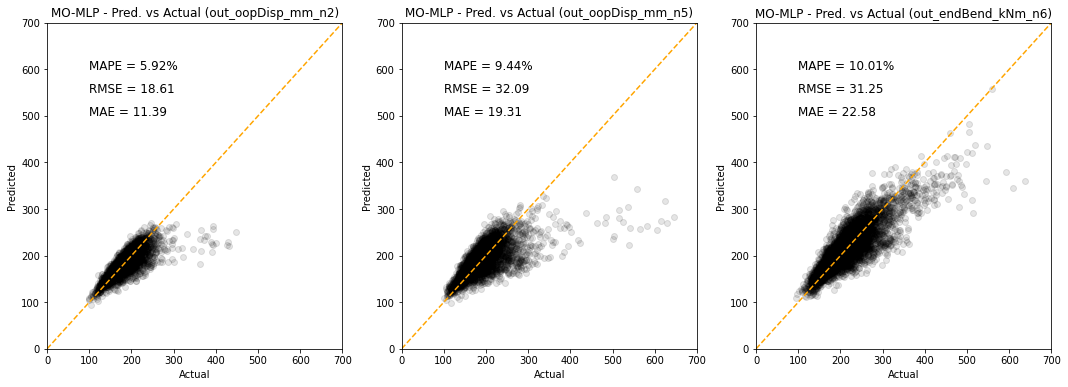

In [33]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

for p in range(3):
    mae = round(globals()[f'mae_momlp_{p}'], 2)
    rmse = round(globals()[f'rmse_momlp_{p}'], 2)
    mape = round(globals()[f'mape_momlp_{p}'], 2)
    ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
    ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
    ax[p].set_title(f'MO-MLP - Pred. vs Actual ({pred_target[p]})')
    ax[p].text(100, 600, f'MAPE = {round(mape, 2)}%', fontsize = 12)
    ax[p].text(100, 550, f'RMSE = {round(rmse, 2)}', fontsize = 12)    
    ax[p].text(100, 500, f'MAE = {round(mae, 2)}', fontsize = 12)    
    ax[p].set_ylim(0, 700)
    ax[p].set_xlim(0, 700)
plt.show()

## 2) Basic MLP MO Model

In [18]:
clf = MLPRegressor(random_state=1, max_iter=3000).fit(X_train.to_numpy(), y_train.to_numpy())
y_pred = clf.predict(X_test.to_numpy())
y_bas = df_inp[pred_target].to_numpy()
scaler_m = preprocessing.StandardScaler()
y_scl = scaler_m.fit_transform(y_bas)

# Inverse transform (scaling) to review metrics such as MAE
y = scaler_m.inverse_transform(y_test)
yhat = scaler_m.inverse_transform(y_pred)

In [19]:
for target in range(3):
    y_t = y[:, target]
    yhat_t = yhat[:, target]

    globals()[f'mae_momlp_{target}'] = metrics.mean_absolute_error(y_t, yhat_t)
    globals()[f'mse_momlp_{target}']  = metrics.mean_squared_error(y_t, yhat_t)
    globals()[f'rmse_momlp_{target}'] = np.sqrt(globals()[f'mse_momlp_{target}']) # or mse**(0.5) 
    globals()[f'mape_momlp_{target}'] = 100*metrics.mean_absolute_percentage_error(y_t, yhat_t)  
    r2 = metrics.r2_score(y_t, yhat_t)

    print(f'\nTarget {target+1}: Results of sklearn.metrics:')
    print("MAE:", round(globals()[f'mae_momlp_{target}'], 2))
    print("MSE:", round(globals()[f'mse_momlp_{target}'], 2))
    print("RMSE:", round(globals()[f'rmse_momlp_{target}'], 2))
    print("MAPE:", round(globals()[f'mape_momlp_{target}'], 2))
    print("R-Squared:", round(r2, 2))


Target 1: Results of sklearn.metrics:
MAE: 5.29
MSE: 56.01
RMSE: 7.48
MAPE: 2.87
R-Squared: 0.94

Target 2: Results of sklearn.metrics:
MAE: 8.81
MSE: 151.44
RMSE: 12.31
MAPE: 4.63
R-Squared: 0.92

Target 3: Results of sklearn.metrics:
MAE: 14.04
MSE: 343.37
RMSE: 18.53
MAPE: 6.45
R-Squared: 0.9


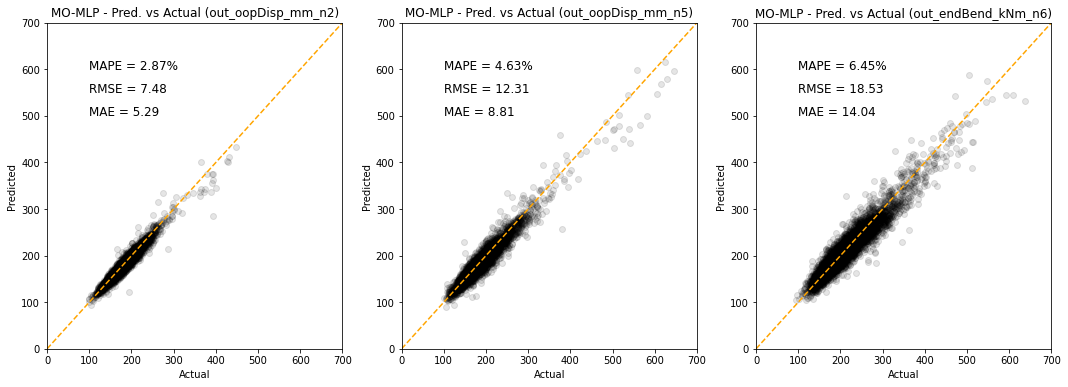

In [20]:
fig, ax = plt.subplots(1, 3, figsize = (18, 6))

for p in range(3):
    mae = round(globals()[f'mae_momlp_{p}'], 2)
    rmse = round(globals()[f'rmse_momlp_{p}'], 2)
    mape = round(globals()[f'mape_momlp_{p}'], 2)
    ax[p].scatter(y[:, p], yhat[:, p], color = 'black', zorder = 1, alpha=0.1)
    ax[p].plot([0, 700], [0, 700], '--', color = 'orange', zorder = 2)
    ax[p].set(ylabel = 'Predicted', xlabel = 'Actual')
    ax[p].set_title(f'MO-MLP - Pred. vs Actual ({pred_target[p]})')
    ax[p].text(100, 600, f'MAPE = {round(mape, 2)}%', fontsize = 12)
    ax[p].text(100, 550, f'RMSE = {round(rmse, 2)}', fontsize = 12)    
    ax[p].text(100, 500, f'MAE = {round(mae, 2)}', fontsize = 12)    
    ax[p].set_ylim(0, 700)
    ax[p].set_xlim(0, 700)
plt.show()

# 3) Tuned MLP MO Model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 126)               1512      
                                                                 
 dense_7 (Dense)             (None, 146)               18542     
                                                                 
 dense_8 (Dense)             (None, 3)                 441       
                                                                 
Total params: 20,495
Trainable params: 20,495
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/300
352/352 [==============================] - 1s 3ms/step - loss: 0.4242 - val_loss: 0.3216
Epoch 2/300
352/352 [==============================] - 1s 2ms/step - loss: 0.2847 - val_loss: 0.2526
Epoch 3/300
352/352 [==============================] - 1s 2ms/step - loss: 0.2150 - val_loss: 0.2094
Epoch 

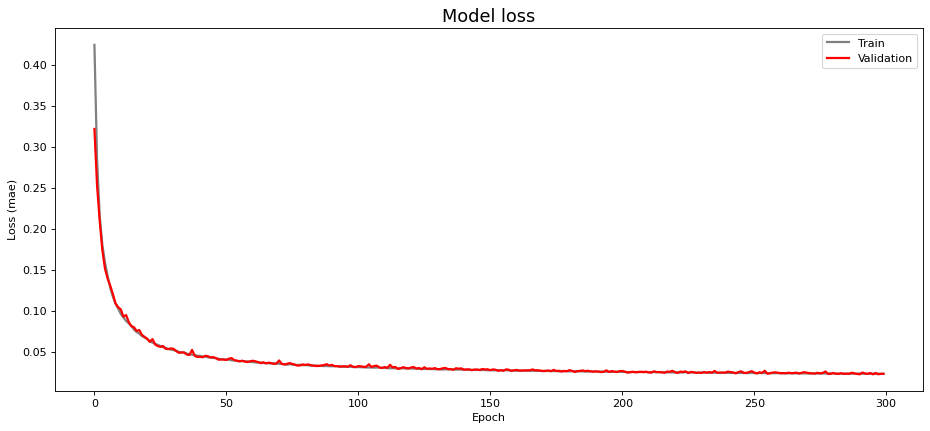


Target 1: Results of sklearn.metrics:
MAE: 3.51
MSE: 23.11
RMSE: 4.81
MAPE: 1.93
R-Squared: 0.98

Target 2: Results of sklearn.metrics:
MAE: 5.51
MSE: 59.17
RMSE: 7.69
MAPE: 2.96
R-Squared: 0.97

Target 3: Results of sklearn.metrics:
MAE: 9.44
MSE: 163.68
RMSE: 12.79
MAPE: 4.45
R-Squared: 0.95


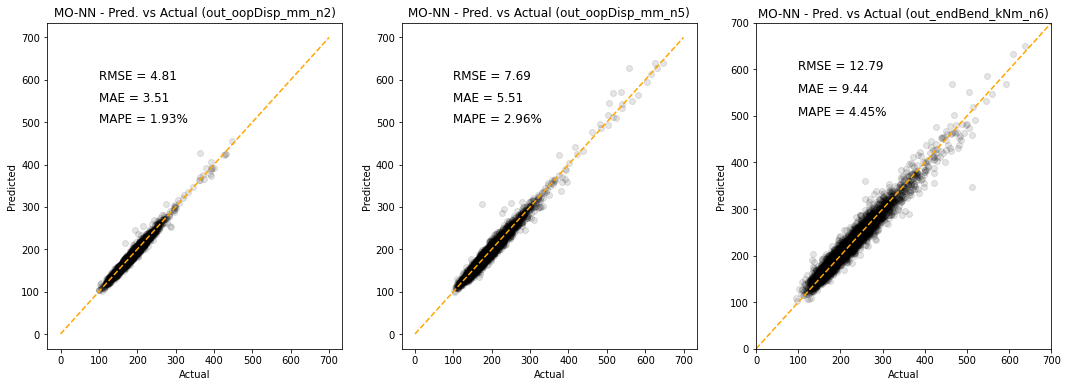

In [34]:
# Model suggested from optimizer
def gen_model104(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(126, input_dim=n_inputs, kernel_initializer='he_uniform', activation='tanh')) 
    model.add(Dense(146, kernel_initializer='he_uniform', activation='tanh'))  
    model.add(Dense(n_outputs, kernel_initializer='he_uniform'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')
    print(model.summary())
    return model

# Train final model & test on unseen test data.
out_104, model_104 = run_model(104, X_test, y_test, bs=128, verb_out=1)

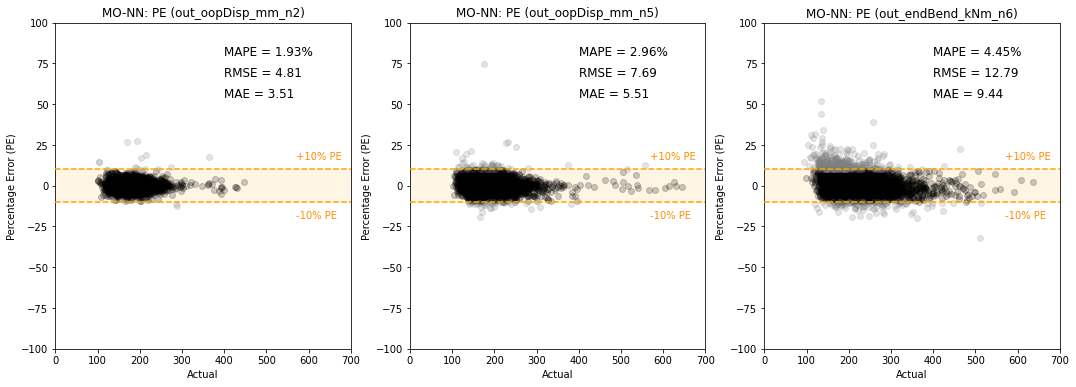

In [35]:
gen_band_output(out_104)